# Input Data & Equivariances

Molecular graphs and structures (xyz coordinates) are the fundamental features in molecules and materials. As discussed, often these are converted into molecular descriptors or some other representation. Why is that? Why can we not work with the data directly? For example, let’s say we have a butane molecule and would like to predict its potential energy from its position. You could train a linear model $\hat{E}$ that predicts energy
$$
\hat{E} = \mathbf{XW}+b
$$
whre $\mathbf{X}$ is 14(atoms)x3(coord) matrix and $\mathbf{W},b$ are trainable parameters. What if I translate all the coordinates by -10?
$$
(\mathbf{X}-10)\mathbf{W}+b=\mathbf{XW}+b-10|\mathbf{W}|
$$
The energy predicted has changed by $-10|\mathbf{W}|$. There is translational variance where it should not be.

Consider another example from our butane molecule. What if we swapped the order of the atoms in our $\mathbf{X}$ matrix. There is no such thing as a “left” or “right” side of our molecule, so it should not matter. However, you’ll see that changing the order of $\mathbf{X}$ changes which weights are multiplied and thus the predicted energy will change. This is called a permutation variance.

## 1. Equivariances

[See](https://dmol.pub/dl/data.html#equivariances)

## 2. Equivariances of Coordinates

[See](https://dmol.pub/dl/data.html#equivariances-of-coordinates)

## 3. Constructing Equivariant Models
[See](https://dmol.pub/dl/data.html#constructing-equivariant-models)


## 4. Examples

We define the butane molecule as a set of coordinates $\mathbf{R}_i$ and features $\mathbf{X}_i$. The features are just one-hot vectors indicating if a point is a C atom [1,0] or a H atom [0,1].


In [2]:
import numpy as np

R_i = np.array(
    [
        -0.5630,
        0.5160,
        0.0071,
        0.5630,
        -0.5159,
        0.0071,
        -1.9293,
        -0.1506,
        -0.0071,
        1.9294,
        0.1505,
        -0.0071,
        -0.4724,
        1.1666,
        -0.8706,
        -0.4825,
        1.1551,
        0.8940,
        0.4825,
        -1.1551,
        0.8940,
        0.4723,
        -1.1665,
        -0.8706,
        -2.0542,
        -0.7710,
        -0.9003,
        -2.0651,
        -0.7856,
        0.8742,
        -2.7203,
        0.6060,
        -0.0058,
        2.0542,
        0.7709,
        -0.9003,
        2.7202,
        -0.6062,
        -0.0059,
        2.0652,
        0.7854,
        0.8743,
    ]
).reshape(-1, 3)
print(R_i.shape)
N = R_i.shape[0]
X_i = np.zeros((N, 2))
print(X_i.shape)
X_i[:4, 0] = 1
X_i[4:, 1] = 1

(14, 3)
(14, 2)



### 4.1. No equivariances

A one-hidden layer dense neural network is an example of a model with no equivariances. To fit our data into this dense layer, we’ll just stack the positions and features into a large input tensor and output energy. We’ll use a tanh as activation, 16 hidden layer dimension, and our output layer has no activation because we’re doing regression to energy. Our weights will always be randomly initialized.

In [16]:
i = np.concatenate((R_i, X_i), axis=1).flatten()
w1 = np.random.rand(5*N, 3)

print(i.shape, w1.shape)

a = i @ w1
print(a, a.shape)

(70,) (70, 3)
[ 6.35963302  8.98093732 10.01576869] (3,)


In [28]:
# our 1-hidden layer model
def hidden_model(r, x, w1, w2, b1, b2):
    i = np.concatenate((r,x), axis=1).flatten()
    v = np.tanh(i @ w1 + b1)
    v = v @ w2 + b2
    return v

w1 = np.random.normal(size=(5 * N, 16))
b1 = np.random.normal(size=(16))
w2 = np.random.normal(size=(16))
b2 = np.random.normal(size=(1))

hidden_model(R_i, X_i, w1, w2, b1, b2)

array([-4.98251])

Now let's see what happens if we translate the molecule.

In [30]:
hidden_model(R_i + 10, X_i, w1, w2, b1, b2)  # Move all coordinates 10 units

array([1.44183249])

The model is not translationally invariant. Let's try rotation using the scipy module

In [31]:
import scipy.spatial.transform as trans

# rotate around x coord by 45 degrees
rot = trans.Rotation.from_euler("x", 45, degrees=True)

print("No rotation", hidden_model(R_i, X_i, w1, w2, b1, b2))
print("Rotated", hidden_model(rot.apply(R_i), X_i, w1, w2, b1, b2))

No rotation [-4.98251]
Rotated [-3.22626167]


Our model is affected by the rotation, meaning it is not rotation invariant. Permutation invariance comes from swapping indices.

In [42]:
# swap 0, 1 rows
perm_R_i = np.copy(R_i)
perm_R_i[0], perm_R_i[1] = R_i[1], R_i[0]
# we do not need to swap X_i 0,1 because they are identical

print("original", hidden_model(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model(perm_R_i, X_i, w1, w2, b1, b2))

original [-4.98251]
permuted [-2.9750891]


Our model is not permutation invariant!

### 4.2. Permutation invariance

We will use a reduction to achieve permutation invariance. All that is needed is to ensure that weights are not a function of our atom number axis and then do a reduction (sum) prior to the output layer. Here is the implementation.

In [43]:
# our 1-hidden layer model with perm inv
def hidden_model_pi(r, x, w1, w2, b1, b2):
    # stack into one large input
    i = np.concatenate((r, x), axis=1)  # We do NOT flatten now so shape -> (N, 5)
    v = np.tanh(i @ w1 + b1)  # shape -> (N, 16)
    print(f'output shape of first layer {v.shape}')
    # reduction
    v = np.sum(v, axis=0)  # Reduce the atoms axis, shape -> (16,)
    print(f'output shape of second layer {v.shape}')
    v = v @ w2 + b2        # Inner product of two (16,) vectors returns scalar
    return v


# initialize our weights
w1 = np.random.normal(size=(5, 16))  # note it no lonegr has N!
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

We made three changes: we kept the atom axis (no more flatten), we removed the atom axis after the hidden layer (sum), and we made our weights not depend on the atom axis. Now let’s observe if this is indeed permutation invariant.

In [45]:
print("original", hidden_model_pi(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model_pi(perm_R_i, X_i, w1, w2, b1, b2))

output shape of first layer (14, 16)
output shape of second layer (16,)
original 5.430440774323379
output shape of first layer (14, 16)
output shape of second layer (16,)
permuted 5.430440774323379


In [46]:
print('original', hidden_model_pi(R_i, X_i, w1, w2, b1, b2))
print('translated', hidden_model_pi(R_i + 5, X_i, w1, w2, b1, b2))

output shape of first layer (14, 16)
output shape of second layer (16,)
original 5.430440774323379
output shape of first layer (14, 16)
output shape of second layer (16,)
translated 30.822373860347046


It is not translationally invariant tho

## 4.3. Translation Invariant
The next change we will make is to convert our Nx3 shaped coordinates into NxNx3 pairwise vectors. This gives us translation invariance. This causes an issue because our distance features went from being 3 per atom to Nx3 per atom. Thus we’ve introduced a dependence on atom number in our distance features and that means it’s easy to accidentally break our permutation invariance. We can just sum over this new axis though. Let’s see an implementation:

In [59]:

# Some code to se what the newaxis does on the next cell
a = np.array([
    [0, 0, 0],
    [1, 2, 3]
])
print(a, a.shape)

print(a[:, np.newaxis], a[:, np.newaxis].shape)

d = a - a[:,np.newaxis]
print(d)
print(d.shape)
# The result es a set of matrices where the vectors from one atom to the rest is
# stored in each one of them

[[0 0 0]
 [1 2 3]] (2, 3)
[[[0 0 0]]

 [[1 2 3]]] (2, 1, 3)
[[[ 0  0  0]
  [ 1  2  3]]

 [[-1 -2 -3]
  [ 0  0  0]]]
(2, 2, 3)


In [60]:
# our 1-hidden layer model with perm inv, trans inv
def hidden_model_pti(r, x, w1, w2, b1, b2):
    # compute pairwise distances using broadcasting
    d = r - r[:, np.newaxis]
    # stack into one large input of N x N x 5
    # concatenate doesn't broadcast, so I manually broadcast the Nx2 x matrix
    # into N x N x 2
    i = np.concatenate((d, np.broadcast_to(x, (d.shape[:-1] + x.shape[-1:]))), axis=-1) # Shape -> (N, N, 5)
    print(i.shape)
    v = np.tanh(i @ w1 + b1)  # Shape -> (N, N, 16)
    print(v.shape)
    # reduction over both axes
    v = np.sum(v, axis=(0, 1))  # Shape -> (16)
    v = v @ w2 + b2  # Shape -> ()
    return v

In [61]:
print("original", hidden_model_pti(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model_pti(perm_R_i, X_i, w1, w2, b1, b2))
print("translated", hidden_model_pti(R_i + np.array([-2, 3, 4]), X_i, w1, w2, b1, b2))
print("rotated", hidden_model_pti(rot.apply(R_i), X_i, w1, w2, b1, b2))

(14, 14, 5)
(14, 14, 16)
original 87.48624364521453
(14, 14, 5)
(14, 14, 16)
permuted 87.48624364521453
(14, 14, 5)
(14, 14, 16)
translated 87.48624364521451
(14, 14, 5)
(14, 14, 16)
rotated 103.73945728536106


It is now translation and permutation invariant. But not yet rotation invariant.

### 4.4. Rotation invariant

Instead of just getting the pairwise vectors we obtain the pairwise distances (in fact, just squares of distances will do).

In [62]:
# our 1-hidden layer model with perm, trans, rot inv.
def hidden_model_ptri(r, x, w1, w2, b1, b2):
    # compute pairwise distances using broadcasting
    d = r - r[:, np.newaxis]
    # x^2 + y^2 + z^2 of pairwise vectors
    # keepdims so we get an N x N x 1 output
    d2 = np.sum(d**2, axis=-1, keepdims=True)
    # stack into one large input of N x N x 3
    # concatenate doesn't broadcast, so I manually broadcast the Nx2 x matrix
    # into N x N x 2
    i = np.concatenate(
        (d2, np.broadcast_to(x, (d2.shape[:-1] + x.shape[-1:]))), axis=-1
    )
    v = np.tanh(i @ w1 + b1)
    # reduction over both axes
    v = np.sum(v, axis=(0, 1))
    v = v @ w2 + b2
    return v


# initialize our weights
w1 = np.random.normal(size=(3, 16))  # now just 1 dist feature
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

# test it

print("original", hidden_model_ptri(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model_ptri(perm_R_i, X_i, w1, w2, b1, b2))
print("translated", hidden_model_ptri(R_i + np.array([-2, 3, 4]), X_i, w1, w2, b1, b2))
print("rotated", hidden_model_ptri(rot.apply(R_i), X_i, w1, w2, b1, b2))

original 85.49010544734598
permuted 85.49010544734593
translated 85.49010544734593
rotated 85.49010544734593


Finally as a sanity check, let’s make sure that if we change the coordinates our predicted energy changes.

In [63]:
R_i[0] = 2.0
print("changed", hidden_model_ptri(R_i, X_i, w1, w2, b1, b2))

changed 75.15191806961771


## 5. Trajectory Alignment Example

Let’s start by loading the trajectory and defining/testing our centering function. The trajectory is a tensor that is shape `time, point number, xy -> (2048, 12, 2)`. I’ll examine two centering functions: align to center of mass and align to point 0 to see what the two look like.

In [65]:
# new imports
import matplotlib.pyplot as plt
import urllib
# import dmol

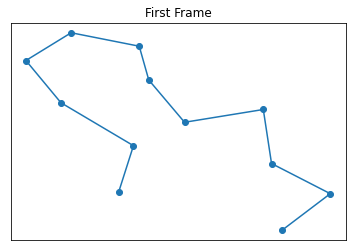

In [66]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/paths.npz", "paths.npz"
)
paths = np.load("paths.npz")["arr"]
# plot the first point
plt.title("First Frame")
plt.plot(paths[0, :, 0], paths[0, :, 1], "o-")
plt.xticks([])
plt.yticks([])
plt.show()

In [67]:
def center_com(paths):
    """Align paths to COM at each frame"""
    coms = np.mean(paths, axis=-2, keepdims=True)
    return paths - coms


def center_point(paths):
    """Align paths to particle 0"""
    return paths - paths[:, :1]


ccpaths = center_com(paths)
cppaths = center_point(paths)

To compare, we’ll draw a sample of frames on top of one another to see the now translationally invariant coordinates.

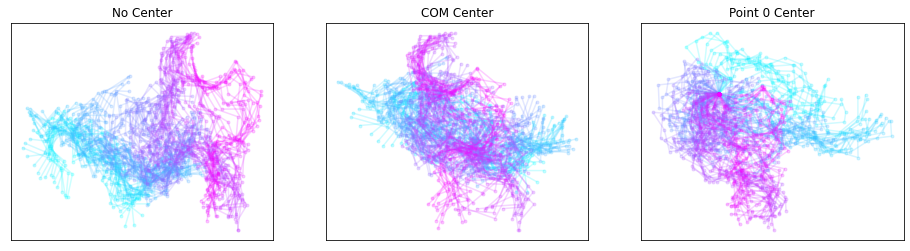

In [68]:
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title("No Center")
axs[1].set_title("COM Center")
axs[2].set_title("Point 0 Center")
cmap = plt.get_cmap("cool")
for i in range(0, 2048, 16):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048))
    axs[1].plot(
        ccpaths[i, :, 0], ccpaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
    axs[2].plot(
        cppaths[i, :, 0], cppaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

The color indicates time. You can see that having no alignment makes the spatial coordinates depend on time implicitly because the points drift over time. Both aligning to COM or point 0 removes this effect.

Now we will align by rotation. We need to define a unique rotation. A simple way is to choose 1 (or 2 in 3D) vectors that define our coordinate system directions. For example, we could choose that the vector from point 0 to point 1 defines the positive direction of the x-axis. A more sophisticated way is to find the principal axes of our points and align along these. For 2D, we only need to align to one of them. Again, this implicitly removes a degree of freedom. We will examine both. Computing principle axes requires an eigenvalue decomposition, so it’s a bit more numerically intense.

In [69]:
def make_2drot(angle):
    mats = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    # swap so batch axis is first
    return np.swapaxes(mats, 0, -1)


def align_point(paths):
    """Align to 0-1 vector assuming 2D data"""
    vecs = paths[:, 0, :] - paths[:, 1, :]
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:, 1], vecs[:, 0])
    rot_angle = -cur_angle
    rot_mat = make_2drot(rot_angle)
    # to mat mult at each frame
    return paths @ rot_mat


def find_principle_axis(points, naxis=2):
    """Compute single principle axis for points"""
    inertia = points.T @ points
    evals, evecs = np.linalg.eig(inertia)
    order = np.argsort(evals)[::-1]
    # return largest vectors
    return evecs[:, order[:naxis]].T


def align_principle(paths, axis_finder=find_principle_axis):
    # someone should tell me how to vectorize this in numpy
    vecs = [axis_finder(p) for p in paths]
    vecs = np.array(vecs)
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:, 0, 1], vecs[:, 0, 0])
    cross = np.cross(vecs[:, 0], vecs[:, 1])
    rot_angle = -cur_angle - (cross < 0) * np.pi
    rot_mat = make_2drot(rot_angle)
    # rotate at each frame
    rpaths = paths @ rot_mat
    return rpaths


appaths = align_point(cppaths)
apapaths = align_principle(ccpaths)

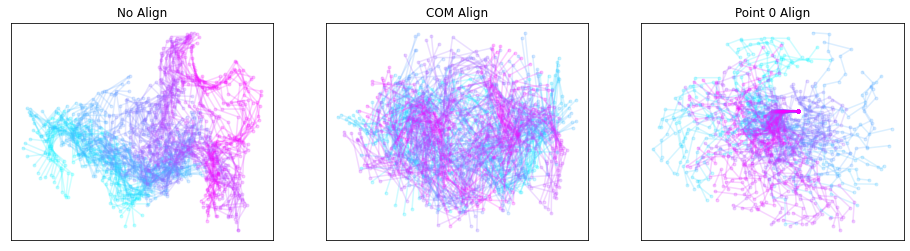

In [70]:
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title("No Align")
axs[1].set_title("COM Align")
axs[2].set_title("Point 0 Align")
for i in range(0, 2048, 16):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048))
    axs[1].plot(
        apapaths[i, :, 0], apapaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
    axs[2].plot(
        appaths[i, :, 0], appaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

You can see how points far away on the chain from 0 have much more variance in the point 0 align, whereas the COM alignment looks better spread. Remember, to apply these methods you must do them to both your training data and any prediction points. Thus, they should be viewed as part of your neural network. We can now check that rotating has no effect on these. The plots below have the trajectory rotated by 1 radian and you can see that both alignment methods have no change (the lines are overlapping).

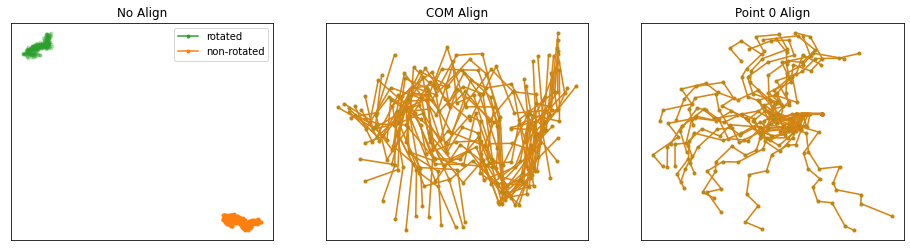

In [72]:
rot_paths = paths @ make_2drot(1)
rot_appaths = align_point(center_point(rot_paths))
rot_apapaths = align_principle(center_com(rot_paths))
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title("No Align")
axs[1].set_title("COM Align")
axs[2].set_title("Point 0 Align")
for i in range(0, 500, 20):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], ".-", alpha=1, color="C1")
    axs[1].plot(apapaths[i, :, 0], apapaths[i, :, 1], ".-", alpha=1, color="C1")
    axs[2].plot(appaths[i, :, 0], appaths[i, :, 1], ".-", alpha=1, color="C1")
    axs[0].plot(rot_paths[i, :, 0], rot_paths[i, :, 1], ".-", alpha=0.2, color="C2")
    axs[1].plot(
        rot_apapaths[i, :, 0], rot_apapaths[i, :, 1], ".-", alpha=0.2, color="C2"
    )
    axs[2].plot(rot_appaths[i, :, 0], rot_appaths[i, :, 1], ".-", alpha=0.2, color="C2")
# plot again to get handles
axs[0].plot(np.nan, np.nan, ".-", alpha=1, color="C2", label="rotated")
axs[0].plot(np.nan, np.nan, ".-", alpha=1, color="C1", label="non-rotated")
axs[0].legend()
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Now which method is better? Aligning based on arbitrary points is indeed easier, but it creates an unusual new variance in your features. For example, let’s see what happens if we make a small perturbation to one conformation. We try changing point 1, then point 0, then point 11 to see the effects of perturbations along the chain.

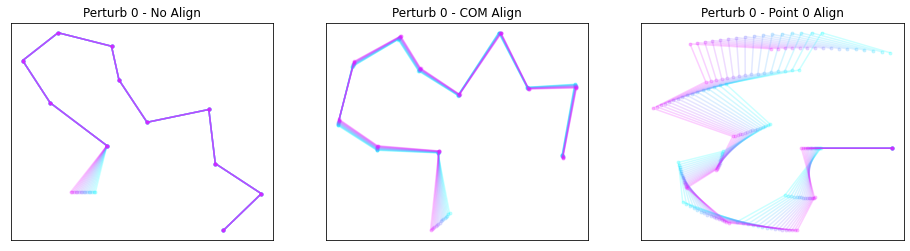

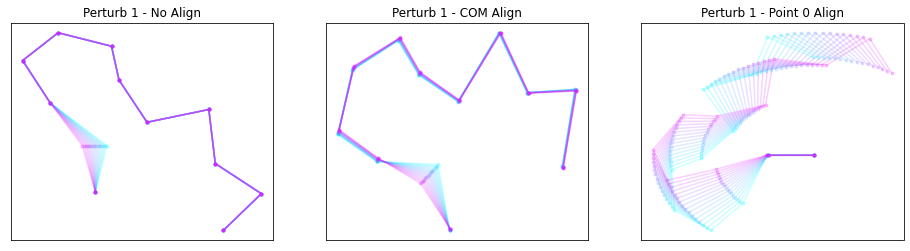

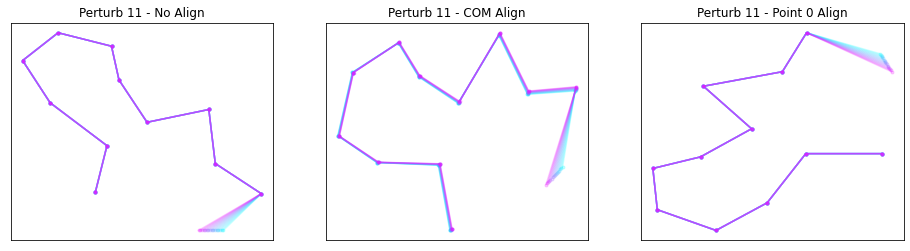

In [73]:
NP = 16


def perturb_paths(perturb_point):
    perturbation = np.zeros_like(paths[:NP])
    perturbation[:, perturb_point, 0] = np.linspace(0, 0.2, NP)
    test_paths = paths[0:1] - perturbation

    # compute aligned trajs
    appaths = align_point(center_point(test_paths))
    apapaths = align_principle(center_com(test_paths))

    fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))
    axs[0].set_title(f"Perturb {perturb_point} - No Align")
    axs[1].set_title(f"Perturb {perturb_point} - COM Align")
    axs[2].set_title(f"Perturb {perturb_point} - Point 0 Align")
    for i in range(NP):
        axs[0].plot(
            test_paths[i, :, 0],
            test_paths[i, :, 1],
            ".-",
            alpha=0.2,
            color=cmap(i / NP),
        )
        axs[1].plot(
            apapaths[i, :, 0], apapaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / NP)
        )
        axs[2].plot(
            appaths[i, :, 0], appaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / NP)
        )
    for i in range(3):
        axs[i].set_xticks([])
        axs[i].set_yticks([])


perturb_paths(0)
perturb_paths(1)
perturb_paths(11)

As you can see, perturbing one point alters all others after alignment. This makes these transformed features sensitive to noise, especially aligning to point 0 or 1. More importantly, this effect is uneven in the alignment to point 0. This can in-turn make training quite difficult. Of course, neural networks are universal approximators so in theory this should not matter. However, I expect that using the COM alignment approach will give better training because the network will not need to account for this unusual variance structure.

The final analysis shows a video of the two frames. One thing you’ll note are the jumps, when the principle axes swap direction. You can see that the ambiguity caused by these can create artifacts.

[See video](https://dmol.pub/_static/images/pas_traj.mp4)

[Continue discussion](https://dmol.pub/dl/data.html#using-unsupervised-methods-for-alignment)

## 6. Summary
- Machine learning models that work with molecules must be permutation invariant, such that if the atoms are rearranged, the output will not change.
- Translational invariance of molecular coordinates is when the coordinates are shifted and the resulting output does not change.
- Rotational invariance is similar, except the molecular coordinates are rotated.
- Data augmentation is when you try to teach your model the various types of equivariances by rotating and translating your training data to create additional examples.
- There are various techniques, such as eigendecomposition or pairwise distance to make molecular coordinates invariant.
- A one-hidden layer dense neural network is an example of a model with no equivariances.
- You can try alignment for trajectories, where each training example has the same ordering and number of atoms.

